## Submission for Dragonfruit software engineering challenge

### Import Libraries

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
from matplotlib.colors import ListedColormap
import pickle
from tqdm import tqdm



### Q1

An ideal data structure for our use case will be a multidimensional matrix. Matrices allows us to easily model and navigate the structure of the parasite and its surroundings using graph algorithms like breadth-first search. Now even if the conventional matrices are very handy for our usecase, they still turn out to be very sparse as we are dealing with binary matrices where the occupancy of the parasite's body is between 25% to 30% of the matrix. This means most of the matrix is empty and taking up space. So we can use compression algorithms like run-length encoding to decrease the size of the matrix. If we consider a 100,000 x 100,000 matrix and 1 bit per cell with a value of 0 or 1, then the original matrix representation will take up about ~10GB of storage depending on how the matrix was created. With run-length encoding we can reduce this storage space as shown in the given example:-

Matrix row: [0,0,0,0,0,0,0,1,1,0,0,0,0,0,0]

Compress Matrix row with Run length encoding: [[0,7],[1,2],[0,6]]

In the worst case scenario where the entire matrix has alternating 1s and 0s, run length encoding will perform worse than the non-encoded matrix. But on an average case, for a 100,000 x 100,000 matrix if we consider the average run length to be 100 and space taken by the [bit value, frequency] to be ~3bytes then the storage space occupied will be:-

No of runs = (10^10) / 100 = 10^8\
Storage space = 10^8 * 10^(-9) * (1/3) = (10^ - 1) * (0.33) = 0.03GB



### Q2
The following parasite class is created to generate sample parasite images using matrices as a data structure.

### Create Parasite samples

In [3]:
class Parasite:

    def __init__(self, image_height, image_width):

        self.H = image_height
        self.W = image_width
        self.image = None
        self.parasite_edges = {}
        self.parasite = None
        self.dye_image = None
        self.initialize_image()


    ### initializes the image matrix and starts the parasite generation process
    def initialize_image(self):
        self.image = [[0 for _ in range(self.H)] for _ in range(self.W)]
        self.create_parasite()

    #Helper function used to check if a cell is within the bounds of the matrix
    def isCellValid(self, cell):
        x, y = cell

        return not( x < 0  or x >= self.H or y < 0 or y >= self.W) 
    
    # Helper function to find the end points of the parasite in each row
    def get_parasite_edges(self, row_id):

        x = row_id
        start = 0
        end = -1
        for y in range(self.W):
            if self.image[x][y] != 0:
                start = y
                break

        for y in range(self.W - 1, -1, -1):
            if self.image[x][y] != 0:
                end = y
                break
        if start == 0 and end == -1 and self.image[start][end] == 0:
            end = 0
        self.parasite_edges[x] = [start,end]


    # Helper function to generate the final parasite by filling any unfilled cells in the parasites body to prevent gaps in the body
    def flood_fill(self):

        for i in range(self.H):
            self.get_parasite_edges(i)

        for x in range(self.H):
            for y in range(self.parasite_edges[x][0],self.parasite_edges[x][1]):
                self.image[x][y] = 1

        self.dye_image = [[self.image[i][j] for j in range(self.W)] for i in range(self.H)]
        self.add_dye()
    
    # Uses breadth first search and randomization to generate a parasite
    def create_parasite(self):

        # Pick a random occupancy percentage between 25% and 30% to define what percentage of the image will be occupied by the parasite
        self.image_occupancy = random.uniform(0.25,0.30)
        valid_directions = [[-1, 0], [0, -1], [0, 1], [1, 0]]

        count = 0
        visited = set()
        self.parasite = []

        # Choose a random starting point to start generating the parasite
        random_start = [random.randint(0, self.H - 1 ), random.randint(0, self.W - 1)]
        q = deque([random_start])
        self.image[random_start[0]][random_start[1]] = 1
        occupancy = (self.image_occupancy * (self.H * self.W))

        #Continue the loop till the size of the parasite crosses the desired occupancy percentage inside the matrix
        while count < occupancy:

            #Run BFS
            while q and count < occupancy:
                node = q.popleft()
                x1,y1 = node
                if (x1,y1) in visited:
                    continue
                visited.add((x1, y1))
                random.shuffle(valid_directions)
                for d in random.sample(valid_directions,2):
                    x2, y2 = x1 + d[0], y1 + d[1]
                    if self.isCellValid([x2,y2]) and self.image[x2][y2] == 0:
                        self.image[x2][y2] = 1
                        self.parasite.append((x2,y2))
                        q.append([x2, y2])
                        count += 1
                    if count > occupancy:
                        break
            
            if count < occupancy:
                if len(self.parasite) > 0:
                    q = deque([random.sample(self.parasite,1)][0])
                else:
                    random_start = [random.randint(0, self.H - 1 ), random.randint(0, self.W - 1)]
                    q = deque([random_start])
        self.flood_fill()
    
    #Helper function that uses BFS and randomization to add dye to the parasites body
    def add_dye(self):

        visited = set()
        valid_directions = [[-1, 0], [0, -1], [0, 1], [1, 0]]

        

        occupancy = random.uniform(0.01, 0.25)
        dye_occupancy = occupancy * self.image_occupancy * self.H * self.W
        count = 0
        while count < dye_occupancy:
            random_start = random.sample(list(self.parasite),1)[0]
            if tuple(random_start) in visited:
                continue
            
            q = deque([random_start])
            while q and count < dye_occupancy:

                x1, y1 = q.popleft()
                if (x1,y1) in visited:
                    continue
                visited.add((x1,y1))
                random.shuffle(valid_directions)
                for d in random.sample(valid_directions,2):
                    x2, y2 = x1 + d[0], y1 + d[1]
                    if self.isCellValid([x2,y2]) and (x2,y2) not in visited:
                        if self.dye_image[x2][y2] == 1:
                            self.dye_image[x2][y2] = 2
                            q.append([x2,y2])
                            count += 1
                if count > dye_occupancy:
                    break
        
        # Second BFS inside the add_dye function to create areas where the dye spills into the outer regions around the parasite's body
        spill_out = random.uniform(0.0, 0.25)* dye_occupancy
        spilloutcount = 0
        valid_parasite_edges = [i for i in self.parasite_edges if self.parasite_edges[i][0] != self.parasite_edges[i][1]]
        visited = set()
        while spilloutcount < spill_out:

            r = random.sample(valid_parasite_edges, 1)[0]
            random_start = [r,self.parasite_edges[r][0]]
            if tuple(random_start) in visited:
                continue
            
            q = deque([random_start])
            while q and spilloutcount < spill_out:

                x1, y1 = q.popleft()
                if (x1,y1) in visited:
                    continue
                visited.add((x1,y1))
                random.shuffle(valid_directions)
                if self.dye_image[x1][y1] > 0:
                    for d in random.sample(valid_directions,2):
                        x2, y2 = x1 + d[0], y1 + d[1]
                        if self.isCellValid([x2,y2]) and (x2,y2) not in visited:
                            if self.dye_image[x2][y2] == 0:
                                self.dye_image[x2][y2] = 2
                                q.append([x2,y2])
                                spilloutcount += 1
                if spilloutcount > spill_out:
                    break

    ### Use Run length encoding for efficient storage of matrices
    def encode_rle(self, binary_matrix):
        encoded = []
        for row in binary_matrix:
            if not row:  
                continue
            count = 1
            prev = row[0]
            row_encoded = []
            for value in row[1:] + [None]:
                if value == prev:
                    count += 1
                else:
                    row_encoded.append((prev, count))  
                    prev = value
                    count = 1
            encoded.append(row_encoded)
        return encoded

    def decode_rle(self,encoded_matrix):
        decoded = []
        for row_encoded in encoded_matrix:
            row = []
            for value, count in row_encoded:
                row.extend([value] * count)
            decoded.append(row)
        return decoded

        


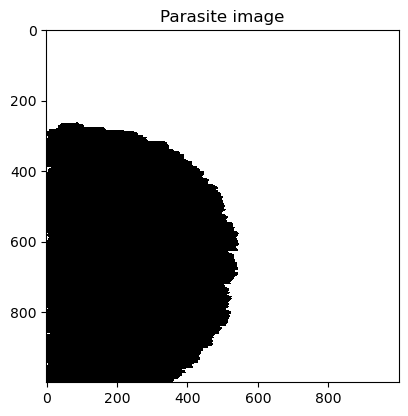

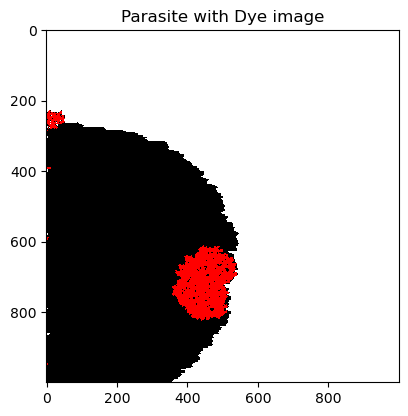

<Figure size 640x480 with 0 Axes>

In [13]:

### Sample parasite

parasite1 = Parasite(1000,1000)

plt.figure(figsize=(10, 10))  # Adjust the size as needed
cmap = ListedColormap(['white', 'black'])
plt.subplot(1,2,1)
plt.imshow(parasite1.image, cmap=cmap)
plt.title("Parasite image")
plt.show()


plt.figure(figsize=(10, 10))  # Adjust the size as needed
cmap = ListedColormap(['white', 'black','red'])
plt.subplot(1,2,2)
plt.imshow(parasite1.dye_image, cmap=cmap)
plt.title("Parasite with Dye image")
plt.show()
plt.tight_layout()


### Q3
Created a group of parasites based on the parasite class from the previous section. The parasite image and their dyed version are then passed into the "hasCancer" function as parameters to verify the presence of cancer.

In [5]:
parasites = []
for i in range(8):
    parasites.append(Parasite(1000,1000))
    print("Parasite "+str(i)+" created")

Parasite 0 created
Parasite 1 created
Parasite 2 created
Parasite 3 created
Parasite 4 created
Parasite 5 created
Parasite 6 created
Parasite 7 created


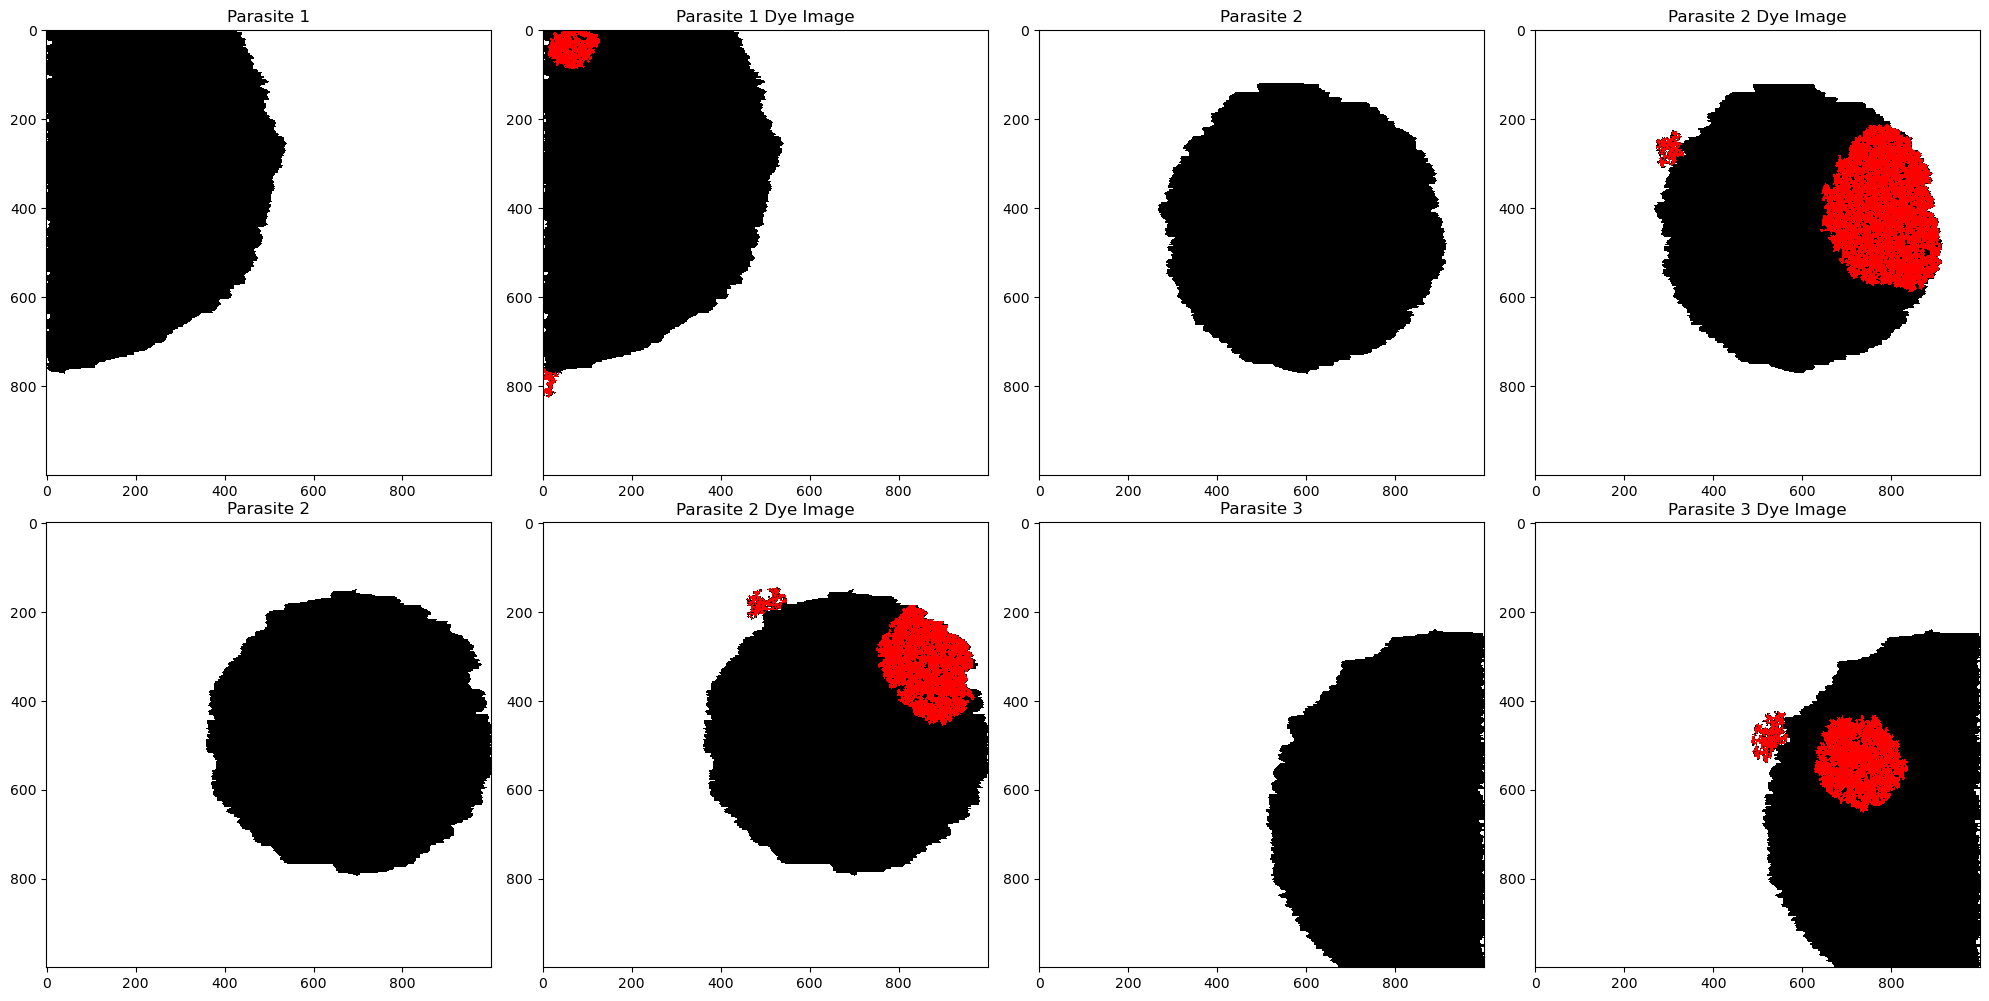

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # figsize(width, height) in inches
count = 0
cmap0 = ListedColormap(['white', 'black'])
cmap1 = ListedColormap(['white', 'black','red'])

for i in range(2):
    axs[i, 0].imshow(parasites[i + count].image, cmap = cmap0)
    axs[i, 0].set_title(f'Parasite {(i) + 0 + 1}')
    axs[i, 1].imshow(parasites[i + count].dye_image, cmap = cmap1)
    axs[i, 1].set_title(f'Parasite {(i) + 1} Dye Image')
    axs[i, 2].imshow(parasites[i + count + 1].image, cmap = cmap0)
    axs[i, 2].set_title(f'Parasite {(i) + 1 + 1}')
    axs[i, 3].imshow(parasites[i + count + 1].dye_image, cmap = cmap1)
    axs[i, 3].set_title(f'Parasite {(i) + 1 + 1} Dye Image')
    count += 1
plt.tight_layout()
plt.show()

In [10]:

def hasCancer(parasite_image, dye_image):

    comb_image = parasite_image * dye_image

    parasite_occupancy = 0
    dye_occupancy = 0

    for i in range(len(comb_image)):
        for j in range(len(comb_image[0])):
            if comb_image[i][j] > 0:
                parasite_occupancy += 1
                if comb_image[i][j] == 2:
                    dye_occupancy += 1

    return (dye_occupancy / parasite_occupancy)

In [11]:
for i in range(len(parasites)):
    parasite = parasites[i]
    x = hasCancer(np.asarray(parasite.image), np.asarray(parasite.dye_image))
    if x > 0.1:
        print("Parasite " + str(i) + " dye occupancy percentage:- " + str(round(x,3)) + " (has Cancer)")
    else:
        print("Parasite " + str(i) + " dye occupancy percentage:- " + str(round(x,3)) + " (Does not have cancer)")


Parasite 0 dye occupancy percentage:- 0.018 (Does not have cancer)
Parasite 1 dye occupancy percentage:- 0.19 (has Cancer)
Parasite 2 dye occupancy percentage:- 0.1 (has Cancer)
Parasite 3 dye occupancy percentage:- 0.084 (Does not have cancer)
Parasite 4 dye occupancy percentage:- 0.199 (has Cancer)
Parasite 5 dye occupancy percentage:- 0.159 (has Cancer)
Parasite 6 dye occupancy percentage:- 0.04 (Does not have cancer)
Parasite 7 dye occupancy percentage:- 0.059 (Does not have cancer)


### Q4
The existing implementation of the cancer detection function is an efficient implementation. Instead of loading and storing two matrices (image and dyed-image) in the memory and iterating through their rows and comparing both the matrices, the current implementation leverages the vectorization properties of the numpy library. An elementwise multiplication is performed to get rid of the areas where the dye has spilled in the dye-image by setting them to 0 as in the original image the value in that cell will be 0. Then we iterate through the final matrix to calculate the dye percentage in the parasite. 

A faster version could be implemented in parallel processing systems like a GPU and their corresponding frameworks like CUDA or a cpu using libraries like OpenMP. As the operations we are doing to compute the dye occupancy on each cell is independent of the other cells, we can parallelize them on the GPU threads and calculate the dye percentage in a single step where a dedicated thread for each cell checks the value and updates our dye occupancy percentage. The following is a sample OpenMP based C code where we do the cancer detection operation using two matrices and we do it parallely.

```c
#include <stdio.h>

#include <stdlib.h>

#include <omp.h>

#define N 1000

int main() {
    int matrix1[N][N], matrix2[N][N];
    int parasiteCellCount = 0;
    int dyeCount = 0;

    for(int i = 0; i < N; i++) {
        for(int j = 0; j < N; j++) {
            matrix1[i][j] = rand() % 3;
            matrix2[i][j] = rand() % 3;
        }
    }

    
    // Using global indexing to access all cells in a single outer loop
    #pragma omp parallel for reduction(+:parasiteCellCount)
    for(int index = 0; index < N*N; index++) {
        int i = index / N; // Calculate row index
        int j = index % N; // Calculate column index
        if(matrix1[i][j] == 1) {
            parasiteCellCount += 1;
            if(matrix2[i][j] == 2){
                dyeCount += 1;
            }
        }
    }

    float occupancy = (float)dyeCount / parasiteCellCount;
    printf("Dye occupancy: %f\n", occupancy);

    return 0;
}

### Q5
Lets take the Runlength encoding as a sample compression technique. We'll also take a sample image of size 100,000 x 100,000 
Device:- Macbook Pro M2-Pro

Binary format:-

Matrix creation time :- ~2hrs

Matrix storage size :-  10.2GB

(Compressed) Run length Encoded format:-

Matrix creation time:- ~5mins

Matrix storage size:- 700MB

In [ ]:
## Run length encoded format
matrix = []
size = 100000
for i in tqdm(range(size)):
    temp = []
    count = 0
    while count < size:
        t = random.randint(30,200)
        val = random.sample([0,1],1)[0]
        temp.append([val,t])
        count += t
    matrix.append(temp)

      

In [ ]:
with open("matrix.pkl","wb") as fp:
    pickle.dump(matrix,fp)

In [3]:
#Binary format

matrix = []
size = 100000
for i in tqdm(range(size)):
    temp = []
    for j in range(size):
        val = random.sample([False,True],1)[0]
        temp.append(val)
    matrix.append(temp)

100%|██████████| 100000/100000 [2:04:06<00:00, 13.43it/s]  


In [16]:
print(len(matrix))

100000


In [4]:
with open("matrix.pkl","wb") as fp:
    pickle.dump(matrix,fp)

### Q6

<b>Tools used</b>


Perplexity :- Look up algorithms and existing techniques

ChatGPT and Claude:- Used for Code Logic improvements and debugging.